<h1>Import libraries<h1>

In [1]:
from Model.K_Nearest_Neighbors_from_scartch import *
from Model.K_Neighbors_Features_optimization import *
from Model.K_Neighbors_Tuning import *
from Metrics.Classification_metrics import *
from Metrics.Regression_metrics import *
from Plots.Prediction_plots import *
from Plots.Algorithms_plots import *
Plots_predictions = Prediction_plots()
Plots_algorithms = Algorithm_plots()

K-Nearest Neighbors (KNN) is an algorithm that can be used for both regression and classification problems. Unlike linear regression, logistic regression or SVM, we are not looking for any functional form of our model; instead, we rely on the fact that:
<br><center><b>The best prediction for a certain observation is the known value for the observation from the training set that is most similar (closest) to the observation for which we are predicting.</b></center></br>
Two observations are similar to each other if they lie close to each other in M - dimensional space (M - number of variables). Various measures can be used to determine this distance:

$$\text{- Euclidean distance: } d_e\left(i,j\right)=\sqrt{\sum_{m=1}^{M}\left(x_{m,i}-x_{m,j}\right)^2}$$
$$\text{- Manhattan distance: } d_e\left(i,j\right)=\sum_{m=1}^{M}\left|x_{m,i}-x_{m,j}\right|$$ 
$$\text{- Cosine similarity: } d_e\left(i,j\right)=\frac{\sum_{m=1}^{M}\left|x_{m,i}-x_{m,j}\right|}{\sum_{m=1}^{M}x_{m,i}\times\sum_{m=1}^{k}x_{m,j}}$$

The number of neighbors (k) is responsible for how many closest observations will be taken into account when deciding what value to assign to the analyzed observation for which we make a prediction. This means that in the case of the problem:
- classificatory: we will determine the prediction equal to the most frequent class among the k nearest neighbors.
- regression: we will determine a prediction equal to the weighted average of the previous k observations:
$$Prediction_i=\frac{y_{closest}\times k+y_{closest-1}\times\left(k-1\right)+\ldots+y_{closest-k+1}\times\left(k-k+1\right)}{k}$$
Of course, different datasets will have different characteristics, so it is always a good idea to perform cross-validation to find the optimal value of k.

<h1>Preprocessing<h1>

<h2>Download data<h2>

In [2]:
data_classification = pd.read_csv("Data/bank-balanced.csv")
data_regression = pd.read_csv("Data/Sales.csv")

Define our target variables

In [3]:
target_classification = "deposit"
target_regression = "Sales"

In [4]:
print("Number of observations in classification data: {}".format(len(data_classification)))
data_classification.head()

Number of observations in classification data: 11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
data_classification.isnull().sum()/len(data_classification)

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
deposit      0.0
dtype: float64

In [6]:
print("Number of observations in regression data: {}".format(len(data_regression)))
data_regression.head()

Number of observations in regression data: 4572


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


In [7]:
data_regression.isnull().sum()/len(data_regression)

TV              0.002187
Radio           0.000875
Social Media    0.001312
Influencer      0.000000
Sales           0.001312
dtype: float64

<h2>Clean regression data<h2>

In [8]:
data_regression.dropna(inplace=True)
print("Number of observations: {}".format(len(data_regression)))

Number of observations: 4546


<h3>Check dtypes of both datasets<h3>

In [9]:
data_regression.dtypes

TV              float64
Radio           float64
Social Media    float64
Influencer       object
Sales           float64
dtype: object

In [10]:
data_classification.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object

We will transform Influencer into numerical using get_dummies function

In [11]:
list_of_object_features_regression = data_regression.select_dtypes(include="object").columns.tolist()
list_of_numeric_features_regression = data_regression.select_dtypes(exclude="object").columns.tolist()
list_of_object_features_classification = data_classification.select_dtypes(include="object").columns.tolist()
list_of_numeric_features_classification = data_classification.select_dtypes(exclude="object").columns.tolist()

Because our target variable in classification dataset is also object, we will remove it and transform it without creating additional columns

In [12]:
list_of_object_features_classification.remove(target_classification)

In [13]:
dummies_regression = pd.get_dummies(data_regression[list_of_object_features_regression], drop_first=True, dtype=float)
data_regression_final = pd.concat([data_regression[list_of_numeric_features_regression], dummies_regression], axis=1)
dummies_classification = pd.get_dummies(data_classification[list_of_object_features_classification], drop_first=True, dtype=float)
data_classification_final = pd.concat([data_classification[list_of_numeric_features_classification], dummies_classification], axis=1)
data_classification_final["deposit"] = pd.factorize(data_classification['deposit'])[0].astype(float)

In [14]:
data_regression_final.head()

,TV,Radio,Social Media,Sales,Influencer_Mega,Influencer_Micro,Influencer_Nano
0,16.0,6.566231,2.907983,54.732757,1.0,0.0,0.0
1,13.0,9.237765,2.409567,46.677897,1.0,0.0,0.0
2,41.0,15.886446,2.913410,150.177829,1.0,0.0,0.0
3,83.0,30.020028,6.922304,298.246340,1.0,0.0,0.0
4,15.0,8.437408,1.405998,56.594181,0.0,1.0,0.0


In [15]:
data_classification_final.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,deposit
0,59,2343,5,1042,1,-1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,56,45,5,1467,1,-1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,41,1270,5,1389,1,-1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,55,2476,5,579,1,-1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,54,184,5,673,2,-1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<h3>Divide our data into train and test sets<h3>

In [16]:
X_regression = data_regression_final.drop("Sales", axis=1)
y_regression = data_regression_final["Sales"]
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, shuffle=True, random_state=17, test_size=0.2)
X_classification = data_classification_final.drop("deposit", axis=1)
y_classification = data_classification_final["deposit"]
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X_classification, y_classification, shuffle=True, random_state=17, test_size=0.2)

Because the distances are simple and absolute measures, outlier observations, or variables with larger nominal values than the others (which, if not significant, can significantly degrade the results), can have a very large impact on the results. For this reason, a very important step for the KNN algorithm is the use of selection and standardization of variables.

<h2>Data scaling<h2>

In [17]:
scaler = MinMaxScaler()
X_regression_numeric_features = X_train_regression.select_dtypes(exclude="object").columns.tolist()
X_train_regression[X_regression_numeric_features] = scaler.fit_transform(X_train_regression[X_regression_numeric_features])
X_test_regression[X_regression_numeric_features] = scaler.transform(X_test_regression[X_regression_numeric_features])
X_classification_numeric_features = X_train_classification.select_dtypes(exclude="object").columns.tolist()
X_train_classification[X_classification_numeric_features] = scaler.fit_transform(X_train_classification[X_classification_numeric_features])
X_test_classification[X_classification_numeric_features] = scaler.transform(X_test_classification[X_classification_numeric_features])

<h1>Modelling<h1>

Find out how our K Nearest Neighbor from scratch works

<h2>Regression<h2>

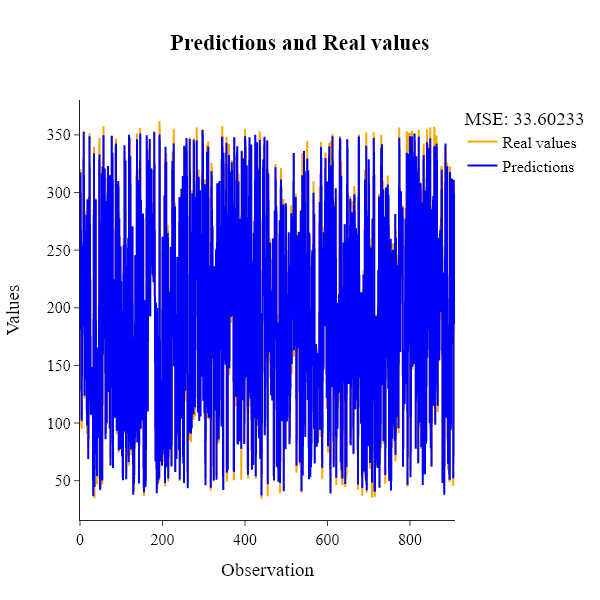

In [18]:
model_regression = KNearestNeighbors(n_neighbors=5, distance="euclidean", random_state=17)
model_regression.fit(X_train_regression, y_train_regression)
y_pred_regression = model_regression.predict(X_test_regression)
Plots_predictions.compare_predictions_with_real_values(y_true=y_test_regression, y_pred=y_pred_regression, metric="MSE")

<h2>Classification<h2>

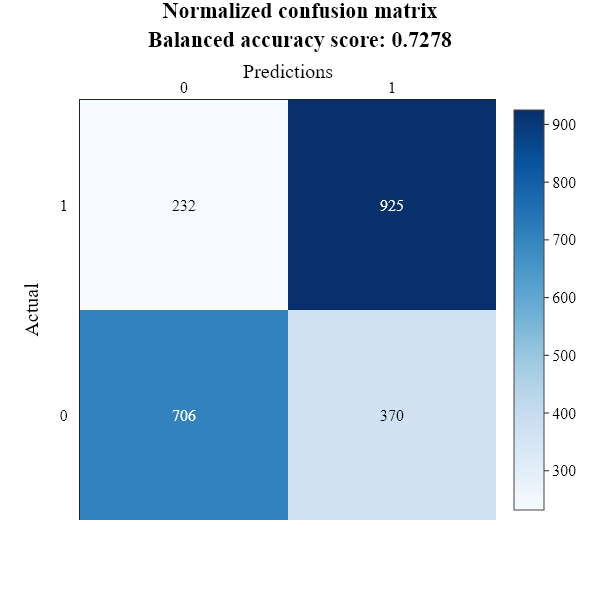

In [19]:
model_classification = KNearestNeighbors(n_neighbors=5, distance="euclidean", random_state=17)
model_classification.fit(X_train_classification, y_train_classification)
y_pred_classification = model_classification.predict(X_test_classification)
Plots_predictions.multilabel_conf_matrix(y_test_classification, y_pred_classification, labels=[i for i in np.unique(y_test_classification)])

Let's write down predictions for the future

In [20]:
base_predictions = y_pred_classification
base_probabilities = model_classification.predict_proba(X_test_classification)[:, 1]

<h1>Tuning<h1>

We will perform tuning of k (number of neighbors), distance type and features scale for classification task

Because our algorithm from scratch is a little bit slower than sklearn ones we will use sklearn's algorithm.

<h2>Number of neighbors tuning<h2>

In [21]:
optimization = KNeighborsOptimization(cross_validation_instance=StratifiedKFold(n_splits=5, shuffle=True, random_state=17))
optimization.optimize(X=X_train_classification, y=y_train_classification, metric="roc_auc", n_neighbors=[i*10 for i in range(1, 16)], distance="euclidean", verbose=False)
optimization.summary_frame

,Number of neighbors,Distance,Mean of Train Scores,Mean of Valid scores
0,30,euclidean,0.828222,0.796538
1,20,euclidean,0.838441,0.795124
2,40,euclidean,0.819367,0.793879
3,10,euclidean,0.864719,0.793431
4,50,euclidean,0.812981,0.792123
5,60,euclidean,0.807773,0.789597
6,70,euclidean,0.803940,0.788534
7,80,euclidean,0.800777,0.787802
8,90,euclidean,0.799007,0.787064
9,100,euclidean,0.796864,0.785936


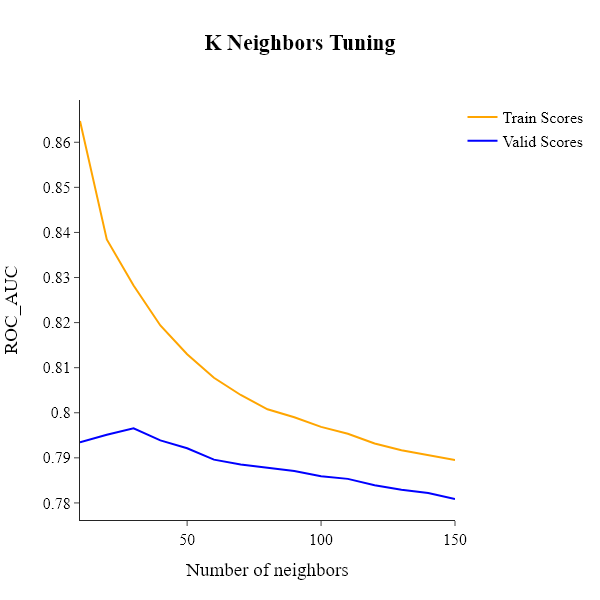

In [22]:
Plots_algorithms.k_neighbors_tuning_plot(n_neighbors=optimization.n_neighbors, train_scores=optimization.train_scores, valid_scores=optimization.valid_scores, metric=optimization.metric)

Based on Train and Valid scores we should now take a look at values from range: [1, 50]

In [23]:
optimization.optimize(X=X_train_classification, y=y_train_classification, metric="roc_auc", n_neighbors=[i*3 for i in range(1, 20)], distance="euclidean", verbose=False)
optimization.summary_frame

,Number of neighbors,Distance,Mean of Train Scores,Mean of Valid scores
0,27,euclidean,0.830914,0.797088
1,30,euclidean,0.828222,0.796538
2,24,euclidean,0.832766,0.796228
3,21,euclidean,0.836746,0.796165
4,33,euclidean,0.824978,0.795928
5,12,euclidean,0.857233,0.795704
6,15,euclidean,0.849149,0.795626
7,18,euclidean,0.842278,0.794990
8,36,euclidean,0.822319,0.794737
9,39,euclidean,0.819867,0.794212


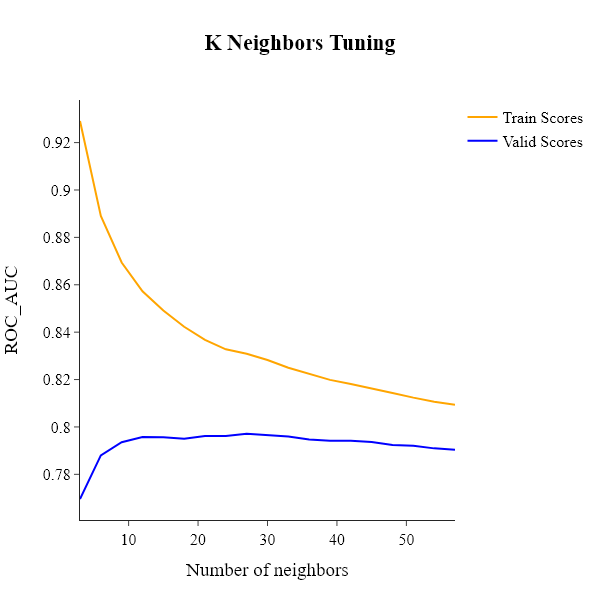

In [24]:
Plots_algorithms.k_neighbors_tuning_plot(n_neighbors=optimization.n_neighbors, train_scores=optimization.train_scores, valid_scores=optimization.valid_scores, metric=optimization.metric)

Based on above output we can see that there is not much difference between specified number of neighbors, and we will simply use the value that provided best scores on our calid data. Therefore while tuning distance metric we will also tune this set of neighbors: {27, 30, 24, 12}.

<h2>Distance tuning<h2>

In [25]:
optimization.optimize(X=X_train_classification, y=y_train_classification, metric="roc_auc", n_neighbors=[27, 30, 24, 12], distance=["euclidean", "manhattan", "cosine"], verbose=False)
optimization.summary_frame

,Number of neighbors,Distance,Mean of Train Scores,Mean of Valid scores
0,30,manhattan,0.835948,0.806612
1,27,manhattan,0.838683,0.806225
2,24,manhattan,0.841956,0.805826
3,12,manhattan,0.864910,0.804018
4,27,euclidean,0.830914,0.797088
5,30,euclidean,0.828222,0.796538
6,24,euclidean,0.832766,0.796228
7,12,euclidean,0.857233,0.795704
8,24,cosine,0.826014,0.788165
9,27,cosine,0.823381,0.787902


The best score was obtained for this set:
$$k=30,\text{ } distance="manhattan"$$

In [26]:
final_algorithm = KNeighborsClassifier(n_neighbors=30, metric="manhattan")

<h2>Features optimization<h2>

First we would like to find out which features might be important "individually". Therefore we will perform something like Forward Feature Selection just to see how our algorithm performs with given feature.

In [27]:
df_train_classification = pd.DataFrame(np.column_stack([X_train_classification, y_train_classification]), columns=data_classification_final.columns)
df_test_classification = pd.DataFrame(np.column_stack([X_test_classification, y_test_classification]), columns=data_classification_final.columns)
feature_names_classification = df_train_classification.drop(target_classification, axis=1).columns.tolist()
df_train_classification.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,deposit
0,0.103896,0.086393,0.100000,0.117040,0.023810,0.329825,0.086207,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.207792,0.081203,0.100000,0.072184,0.047619,0.148538,0.051724,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.116883,0.284324,0.366667,0.138953,0.380952,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.038961,0.081850,0.833333,0.033256,0.023810,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.168831,0.080522,0.733333,0.078113,0.023810,0.985965,0.017241,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
features_optimiser = Features_optimization(cross_validation_instance=StratifiedKFold(n_splits=5, shuffle=True, random_state=17))
features_optimiser.compare_features(df=df_train_classification, metric="roc_auc", algorithm_instance=final_algorithm, feature_set=feature_names_classification, target_name=target_classification, compare=True, verbose=False)
single_feature_importance = features_optimiser.summary_frame
single_feature_importance

,Feature,Mean of Train Scores,Mean of Valid scores
0,duration,0.817366,0.788657
1,contact_unknown,0.603967,0.603967
2,housing_yes,0.603589,0.603591
3,pdays,0.612123,0.600264
4,poutcome_unknown,0.597622,0.597621
5,previous,0.596516,0.593928
6,age,0.595325,0.586224
7,poutcome_success,0.584106,0.584107
8,day,0.590941,0.582357
9,month_may,0.577443,0.577444


In [29]:
features_optimiser = Features_optimization(cross_validation_instance=StratifiedKFold(n_splits=5, shuffle=True, random_state=17))

Based on results we can clearly see that best feature is duration and worst is education_tertiary.

In the next step we will try to find appropriate scale for specified features (two best and worst variables) to improve results.

In [30]:
features_optimiser.change_features_scale(df=df_train_classification, metric="roc_auc", algorithm_instance=final_algorithm, features_to_scale=["duration", "contact_unknown", "education_tertiary", "marital_single"], target_name=target_classification, scale=[0.2, 0.5, 3, 5], verbose=False)

In [31]:
features_optimiser.summary_frame

,duration_scale,contact_unknown_scale,education_tertiary_scale,marital_single_scale,Mean of Train Scores,Mean of Valid scores
0,5.0,0.5,3.0,0.2,0.892480,0.872937
1,5.0,3.0,0.5,0.2,0.889472,0.871750
2,5.0,3.0,0.2,0.5,0.888898,0.870779
3,5.0,0.2,3.0,0.5,0.888109,0.867316
4,5.0,0.5,0.2,3.0,0.886526,0.865471
5,5.0,0.2,0.5,3.0,0.882907,0.861497
6,3.0,0.5,5.0,0.2,0.874004,0.850666
7,3.0,5.0,0.5,0.2,0.870732,0.849613
8,3.0,5.0,0.2,0.5,0.870295,0.848122
9,3.0,0.2,5.0,0.5,0.869926,0.845281


As expected, the best results were obtained when the largest scale was assigned to the duration variable. It is interesting to note that we would have had a higher prediction quality when a higher weight was assigned to the education_tertiary variable (theoretically worst) than to the contact_unknown variable (theoretically second best). 

This is just a confirmation that Forward Selection is not the best algorithm for feature selection.

Right now we can spend a bit more time and change feature scale individually

Variable: Duration

In [32]:
features_optimiser.change_features_scale(df=df_train_classification, metric="roc_auc", algorithm_instance=final_algorithm, features_to_scale=["duration"], target_name=target_classification, scale=[i for i in np.arange(1, 8, 1)], verbose=False)
features_optimiser.summary_frame

,duration_scale,Mean of Train Scores,Mean of Valid scores
0,7,0.899145,0.881281
1,6,0.893817,0.875283
2,5,0.887113,0.867693
3,4,0.879121,0.857633
4,3,0.869185,0.845372
5,2,0.856190,0.830099
6,1,0.835948,0.806612


As you can see, the results improve as the duration weight increases. However, we should not use too much weighting for a single feature, as this can lead to overfitting and dependence of KNN on only one feature.

We have to transform our dataset now.

In [33]:
df_train_classification["duration"] = df_train_classification["duration"]*features_optimiser.summary_frame.iloc[0,0]
X_train_classification["duration"] = X_train_classification["duration"]*features_optimiser.summary_frame.iloc[0,0]
df_test_classification["duration"] = df_test_classification["duration"]*features_optimiser.summary_frame.iloc[0,0]
X_test_classification["duration"] = X_test_classification["duration"]*features_optimiser.summary_frame.iloc[0,0]

To the same for rest of the features

In [34]:
features = X_train_classification.columns.tolist()
features.remove("duration")
for feature in features:
    index = single_feature_importance.loc[single_feature_importance["Feature"]==feature].index[0]
    if(index < len(features)//2):
        scale = [i for i in np.arange(1, 8, 1)]
    else:
        scale = [i for i in np.arange(0, 1, 0.2)]
    features_optimiser.change_features_scale(df=df_train_classification, metric="roc_auc", algorithm_instance=final_algorithm, features_to_scale=feature, target_name=target_classification, scale=scale, verbose=False)
    df_train_classification[feature] = df_train_classification[feature]*features_optimiser.summary_frame.iloc[0,0]
    X_train_classification[feature] = X_train_classification[feature]*features_optimiser.summary_frame.iloc[0,0]
    df_test_classification[feature] = df_test_classification[feature]*features_optimiser.summary_frame.iloc[0,0]
    X_test_classification[feature] = X_test_classification[feature]*features_optimiser.summary_frame.iloc[0,0]

Obviously we could spend more time on optimization. Maybe right now it would be better for our modified data to use euclidean distance and more/less neighbors? Well it is not a case in this example, I just wanted to show some possibilities and how to tune KNN algorithm.

<h1>Evaluation<h1>

We would like to compare base algorithm with our final estimator and modified data.

Base estimator: n_neighbors=5, metric="euclidean", features scale not modified

In [35]:
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test_classification, y_pred=base_predictions), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test_classification, y_score=base_probabilities), 5)))
report = classification_report(y_test_classification, base_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.72781
Roc AUC score: 0.78701
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.752665 | 0.656134 |   0.701092 | 1076        |
| 1.0          |    0.714286 | 0.799481 |   0.754486 | 1157        |
| accuracy     |    0.730408 | 0.730408 |   0.730408 |    0.730408 |
| macro avg    |    0.733475 | 0.727808 |   0.727789 | 2233        |
| weighted avg |    0.732779 | 0.730408 |   0.728758 | 2233        |
+--------------+-------------+----------+------------+-------------+


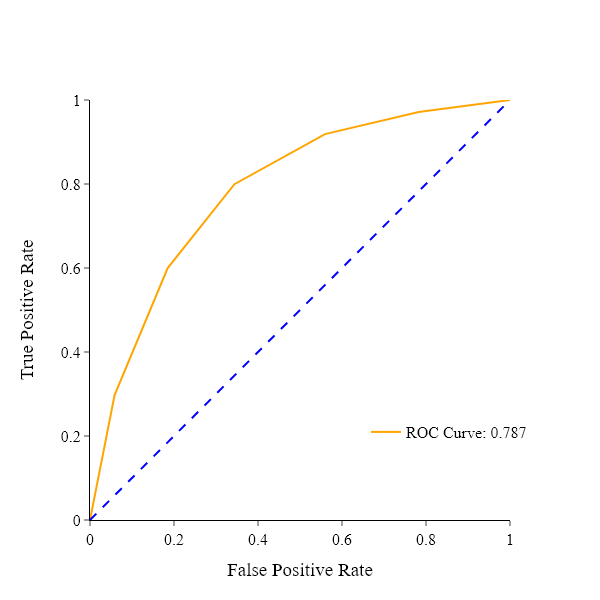

In [36]:
Plots_predictions.roc_auc_plot(y_true=y_test_classification, y_prob=base_probabilities)

Final estimator: n_neighbors=30, metric="manhattan", features scale modified

In [37]:
final_algorithm.fit(X_train_classification, y_train_classification)
y_pred_final = final_algorithm.predict(X_test_classification)
y_prob_final = final_algorithm.predict_proba(X_test_classification)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test_classification, y_pred=y_pred_final), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test_classification, y_score=y_prob_final), 5)))
report = classification_report(y_test_classification, y_pred_final, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.81743
Roc AUC score: 0.9118
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.860814 | 0.747212 |   0.8      | 1076        |
| 1.0          |    0.790608 | 0.88764  |   0.836319 | 1157        |
| accuracy     |    0.819973 | 0.819973 |   0.819973 |    0.819973 |
| macro avg    |    0.825711 | 0.817426 |   0.81816  | 2233        |
| weighted avg |    0.824438 | 0.819973 |   0.818818 | 2233        |
+--------------+-------------+----------+------------+-------------+


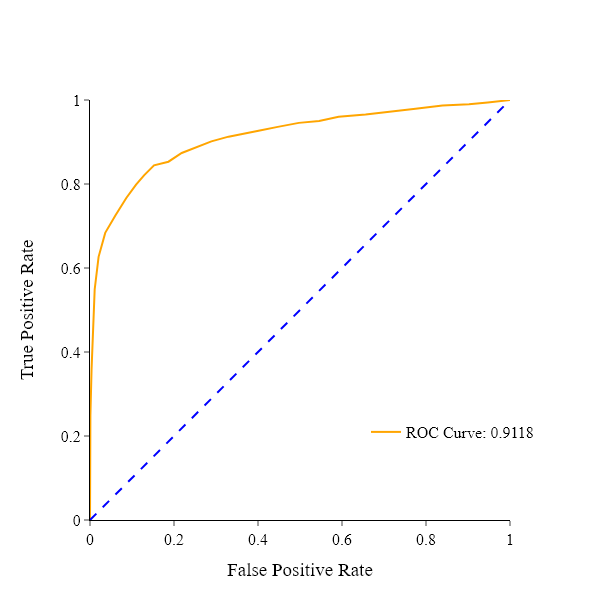

In [38]:
Plots_predictions.roc_auc_plot(y_true=y_test_classification, y_prob=y_prob_final)

As we can see accuracy and roc_auc score increased much by tuning KNN classifier.